In [1]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Conv2D,Dense,MaxPooling2D,Input,Flatten
import tensorflow as tf

In [3]:
#Avoid our memory error by setting GPU memory consumption Growth

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Create Folder Structure

In [5]:
# setup path 
POS_PATH = os.path.join(r'D:\dataset\data', 'positive')
NEG_PATH = os.path.join(r'D:\dataset\data', 'negative')
ANC_PATH = os.path.join(r'D:\dataset\data','anchor')

In [6]:
POS_PATH

'D:\\dataset\\data\\positive'

In [16]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [28]:
# Move LFW Image in Following repository

source_directory = r'D:\dataset\lfw'
destination_directory = r'D:\dataset\data\negative'

for directory in os.listdir(source_directory):
    directory_path = os.path.join(source_directory, directory)

    if os.path.isdir(directory_path):
        for file in os.listdir(directory_path):
            source_path = os.path.join(directory_path, file)
            destination_path = os.path.join(destination_directory, file)
            os.replace(source_path, destination_path)

### collect poitive and anchor classes

In [7]:
import uuid

In [57]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
     ret,frame = cap.read()
     frame = frame[120:120+250,200:200+250,:]
     cv2.imshow('Image Collection',frame)

    
     if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)

     if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)
    
     if cv2.waitKey(1) & 0XFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [44]:
os.path.join(ANC_PATH, '{}'.format(uuid.uuid1()))

'D:\\dataset\\data\\anchor\\9beac06a-b9c3-11ee-8ab1-010101010000'

In [55]:
cap.release()
cv2.destroyAllWindows()

#### NEW - Data Augmentation

In [8]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [10]:
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

### Get Image Directories

In [54]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [55]:
dir_test = anchor.as_numpy_iterator().next()

In [56]:
dir_test

b'D:\\dataset\\data\\anchor\\be5e73a3-bc37-11ee-b0d4-010101010000.jpg'

### Preprocessing -Scale and Resize 

In [57]:
def preprocess(file_path):
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)
    # preeprocessing step - resizing the image to be 100x100x300
    img = tf.image.resize(img,(100,100))
    # scale image to be between 0 and 1
    img = img/255.0
    # return image
    return img 

### create Labelled Dataset

In [58]:
# (anchor,positive) => 1,1,1,1,1
# (anchor,negative) => 0,0,0,0,0

In [114]:
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [115]:
len(data)

6000

In [116]:
negatives.as_numpy_iterator().next()

(b'D:\\dataset\\data\\anchor\\bce000bb-bc37-11ee-a2f6-010101010000.jpg',
 b'D:\\dataset\\data\\negative\\Martin_Brodeur_0001.jpg',
 0.0)

In [138]:
sample = data.as_numpy_iterator()

In [146]:
example = sample.next()

In [147]:
example

(b'D:\\dataset\\data\\anchor\\b22b21a6-bc37-11ee-9192-010101010000.jpg',
 b'D:\\dataset\\data\\positive\\5b5e9c29-bc37-11ee-bc0f-010101010000.jpg',
 1.0)

### Build Train and Test Partition

In [141]:
def preprocess_twin(input_img,validation_img,label):
    return(preprocess(input_img),preprocess(validation_img),label)


In [148]:
res = preprocess_twin(*example)

(-0.5, 99.5, 99.5, -0.5)

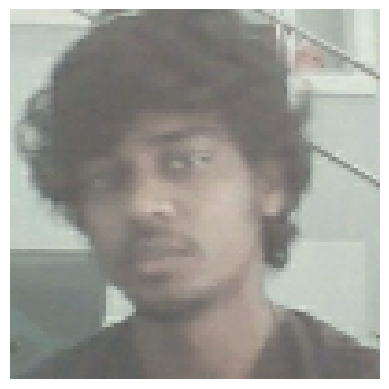

In [149]:
plt.imshow(res[1])
plt.axis('off')

In [150]:
res[2]

1.0

In [151]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [152]:
# training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(32)
train_data = train_data.prefetch(8)

In [153]:
# test partition 
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(32)
test_data = test_data.prefetch(8)

In [154]:
len(test_data)

57

In [224]:
# 600*30/100 => test_data(30%) --> 180
# 600*70/100 => train_data(70%) -- 420

### Model Engineering

#####  Build Embedding Layer

In [155]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D((2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D((2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D((2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4050, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [156]:
embedding = make_embedding()

In [157]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

#### Build Distance Layer

In [158]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [159]:
l1 = L1Dist()

#### Make Siamese Model

In [160]:
def make_siamese_model(): 
    
     # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [161]:
siamese_model = make_siamese_model()

In [162]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4050)         38536466    ['input_img[0][0]',              
                                                                  'validation_img[0][

#### Training

In [163]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [164]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

#### Establish Checkpoints

In [165]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

#### Build Train Step Function

In [166]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

#### Build Training Loop

In [167]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [168]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

#### Train the model

In [169]:
EPOCHS = 50

In [170]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
132/132 [==============================] - 40s 154ms/step
0.0024142244 0.97071534 0.9887531

 Epoch 2/50
132/132 [==============================] - 21s 156ms/step
0.004165319 0.9947644 0.9976134

 Epoch 3/50
 26/132 [====>.........................] - ETA: 16s

KeyboardInterrupt: 

#### Evaluate Model

In [171]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [172]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 27ms/step


In [173]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0]

In [174]:
y_true

array([0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0.,
       1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
      dtype=float32)

In [175]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 30ms/step
0.9977452 0.9988713


#### Viz Results

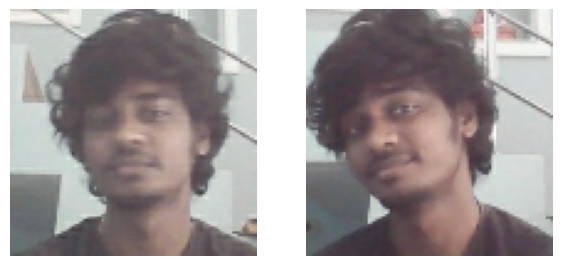

In [178]:
# Set plot size 
plt.figure(figsize=(7,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[2])
plt.axis('off')
# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[2])
plt.axis('off')
# Renders cleanly
plt.show()

#### Save Model

In [179]:
# Save weights
siamese_model.save('siamesemodelV3.h5')

In [180]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv3.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

### Real Time Test

##### Verification Function

In [181]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_images', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

#### OpenCV Real Time Verification

In [182]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_images', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 31ms/step
True
1/1 [==============================] - 0s 16ms/step
False
1/1 [==============================] - 0s 32ms/step
False
1/1 [==============================] - 0s 25ms/step
False
1/1 [==============================] - 0s 27ms/step
True
1/1 [==============================] - 0s 44ms/step
True
1/1 [==============================] - 0s 28ms/step
True
1/1 [==============================] - 0s 26ms/step
True
1/1 [==============================] - 0s 36ms/step
False


In [366]:
cap.release()
cv2.destroyAllWindows()

In [503]:
np.sum(np.array(results) > 0.5)

40

#### Testing with my frnd pic

In [189]:
resultss = []

for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(r"D:\test_images\pacha4.jpg")
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = siamese_model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        resultss.append(result)
    
# Detection Threshold: Metric above which a prediciton is considered positive 
detection = np.sum(np.array(resultss) > 0.5)

# Verification Threshold: Proportion of positive predictions / total positive samples 
verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
verified = verification > 0.5
print(verified)
print(detection)

1/1 [==============================] - 0s 27ms/step
False
10


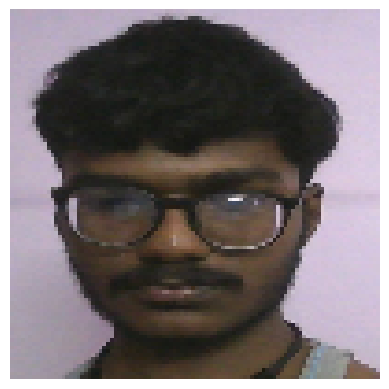

In [190]:
plt.imshow(input_img)
plt.axis('off');